# Help vision impaired people to see the world

Combining leading edge technologies for helping people – Connect the dots:


1. **Classifying** different **pictures** (tickets, floorplans and documents)
2. **Recognizing text** in the images
3. Reading out loud through **text-to-speech** (English)



##<font color=red>Advice:</font>
<font color=red>To train the network fast, from the Runtime environment Menu, select the GPU Hardware Acceleration.

In Spanish 'Entorno de ejecucion -> Cambiar tipo de entorno de ejecución -> Acelerador por Hardware: GPU'.</font>

## Classifying different pictures

**Tools**:

Image Classification to explore:
*   `Sklearn`: Feature Extraction + Traditional Machine Learning
*   `Pytorch`: Convolutional Neural Networks + Transfer Learning (e.g., ImageNet)

---
**Goals**

To measure the categorization between tickets, floorplans and documents.
Image Classification:
*   Confusion Matrix
*   Accuracy = 0.90

---
**Deliverables**

Github Code (master) and Pages (report) Executable:
*   Input: image (.png, .jpg)
*   Output: caption (.txt)

---


**STEPS:**

1. Getting the data
2. Loading and normalizing the data
3. Visualizing a few images
4. Training a CNN as fixed feature extractor with Transfer Learning
5. Visualizing the model predictions
6. Evaluating the model predictions
7. Saving the model
8. Predicting single image using the model



### 1. Getting the data
We upload the `Database.zip` to Drive account and unzip the dataset, which consists of 3 subdirectories (i.e., Documents, Plans and Tickets) each containing images of the corresponding paper category. The path format is `DatabaseOrdered/set_type/class_name/image_id.jpg`



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import necessary packages
from imutils import paths
import numpy as np
import shutil
import os
import zipfile

In [4]:
# specify path to the dataset
ROOT = "/content/drive/MyDrive/ColabNotebooks/"
DOCS_DATASET_PATH = "Database"

# specify the paths to our training and validation set 
TRAIN = "train"
TEST = "test"

classes = ['Documents', 'Plans', 'Tickets']

In [ ]:
def load_Database_Data_paths(dir, filename, typeSet, subcarpeta=''):
    """ load single batch of documents' type """
    # open external ZIP file
    with zipfile.ZipFile(dir+'.zip', 'r') as external_zip:
      # open internal ZIP file
      with external_zip.open(filename+'.zip') as internal_zip:
        with zipfile.ZipFile(internal_zip, 'r') as internal_zip_file:
          internal_zip_file.extractall(dir)
          filenames = internal_zip_file.namelist()
          # select the image set files that belongs to the indicated set
          image_filenames = [f for f in filenames if (f.endswith('.jpg') or f.endswith('.png')) and (f.startswith(filename+'/'+subcarpeta+typeSet))]
          print(typeSet, ': ', len(image_filenames), ' ', image_filenames[0])

          return image_filenames

def load_Database_paths(ROOT, file):
    """ load all of Database """
    xtrains = []
    xtests = []

    ytrains = []
    ytests = []

    for c in classes:
        dir = os.path.join(ROOT, file)

        print('--------------', c, '-------------')
        if c == 'Tickets':
          Xtrain = load_Database_Data_paths(dir, c, 'train', subcarpeta='imges/')
        else:
          Xtrain = load_Database_Data_paths(dir, c, 'train')
        xtrains = xtrains + Xtrain

        if c == 'Tickets':
          Xtest = load_Database_Data_paths(dir, c, 'test', subcarpeta='imges/')
        else:
          Xtest = load_Database_Data_paths(dir, c, 'test')
        xtests = xtests + Xtest

        Ytrain = np.repeat(c, len(Xtrain))
        ytrains = ytrains + Ytrain.tolist()

        Ytest = np.repeat(c, len(Xtest))
        ytests = ytests + Ytest.tolist()
        print('\n')

    print('Xtrains', len(xtrains))
    print('Ytrains', len(ytrains))
    print('Xtests', len(xtests))
    print('Ytests', len(ytests))


    return xtrains, ytrains, xtests, ytests


In [ ]:
X_train, y_train, X_test, y_test = load_Database_paths(ROOT, DOCS_DATASET_PATH)

-------------- Documents -------------
train :  344   Documents/train/a04-089.png
test :  181   Documents/test/d04-117.png


-------------- Plans -------------
train :  606   Plans/train/01_PlantaPCI_A1_reconstructed.png
test :  203   Plans/test/Drawing_1924808_0.png


-------------- Tickets -------------
train :  470   Tickets/imges/train/000.jpg
test :  156   Tickets/imges/test/470.jpg


Xtrains 1420
Ytrains 1420
Xtests 540
Ytests 540


### 2. Loading and normalizing the data

In this step we order the data sets by creating the `DatabaseOrdered` directory, which will contain the data set to be used from now on, grouped by the set type (train or test). So after sorting the dataset, each image will have a path with the following format, `DatabaseOrdered/set_type/class_name/image_id.jpg`

In [ ]:
def copy_images(imagePaths, folder):
  if not os.path.exists(folder):
    os.makedirs(folder)
    print(folder)
    
  for path in imagePaths:
    imageName = path.split(os.path.sep)[-1]
    typeSet = path.split(os.path.sep)[-2]
    label = path.split(os.path.sep)[-3]
    if label == 'imges':
      label = path.split(os.path.sep)[-4]
    labelFolder = os.path.join(folder, label)
		# check to see if the label folder exists and if not create it
    if not os.path.exists(labelFolder):
      os.makedirs(labelFolder)
		# construct the destination image path and copy the current image to it
    destination = os.path.join(labelFolder, imageName)

    shutil.copy(ROOT+DOCS_DATASET_PATH+'/'+path, destination)

In [ ]:
# copy the training and validation images to their respective directories
NEW_DATA_PATH = 'DatabaseOrdered'
if not os.path.exists(ROOT+NEW_DATA_PATH):
    os.makedirs(NEW_DATA_PATH)

print("copying training and testing images...")
copy_images(X_train, ROOT+NEW_DATA_PATH+'/'+TRAIN)
copy_images(X_test, ROOT+NEW_DATA_PATH+'/'+TEST)
print('DONE!')

copying training and validation images...
DONE!


In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [7]:
# data augmentation and normalization for training
# just normalization for test
data_transforms = {
       'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),       # convert the image to a tensor with pixels in the range [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),       # resize the short side of the image to 150 keeping aspect ratio
        transforms.CenterCrop(224),   # crop a square in the center of the image
        transforms.ToTensor(),        # convert the image to a tensor with pixels in the range [0, 1]
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# copy the training and testing images to their respective directories
NEW_DATA_PATH = 'DatabaseOrdered'

image_datasets = {x: datasets.ImageFolder(os.path.join(ROOT+NEW_DATA_PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

print(image_datasets)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

print(dataloaders)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

print(class_names)

{'train': Dataset ImageFolder
    Number of datapoints: 1420
    Root location: /content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'test': Dataset ImageFolder
    Number of datapoints: 540
    Root location: /content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fe2bc972730>, 'test': <torch.uti

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 3. Visualizing a few images

We define the `imshow` function for unnormalizing and displaying the images.
We visualize a few training images after applying data augmentation.

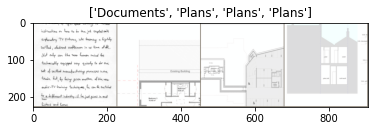

In [42]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    #plt.gcf().set_facecolor("#103243")

    plt.imshow(inp)
    if title is not None:
        #plt.title(title, color='white')
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 4. Training a CNN as fixed feature extractor with Transfer Learning

We define `train_model`, a general function to train a model.

The parameters are the model, the criterion (loss function), the optimizer, the learning rate scheduler (how to modify the learning rate as the learning progresses) and the number of epochs.

In particular, we will see how to schedule the learning rate, and how to save the best model, that is the model that achieves the best performance on the test set.


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # each epoch has a training and test phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # set model to training mode
            else:
                model.eval()   # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We freeze all the network except the final layer. We will only train the parameters of the last layer (the classification layer). For that we need to set ``requires_grad == False`` 
to freeze the parameters so that the gradients are not computed in the backward pass ``backward()``.

We will use as model a resnet18 architecture pretrained on the ImageNet dataset (it contains 1000 classes). Therefore, we will
need to change the number of output units from 1000 to 3, since we will work with only three classes (documents, plans and tickets). 

Parameters: 
- cross entropy loss
- optimizer is stochastic gradient descent (SGD) with momentum (0.9)
- the initial learning rate is 0.001
- the scheduler is StepLR with step_size=7 and gamma=0.1, which means that we reduce the learning rate by a factor of 0.1 every 7 iterations.

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3) # 3 classes to predict

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

We train the model for 25 epochs. The training will be fast as gradients don't need to be computed for most of the network.

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.4823 Acc: 0.7930
test Loss: 0.0517 Acc: 0.9963

Epoch 1/14
----------
train Loss: 0.3778 Acc: 0.8549
test Loss: 0.0376 Acc: 0.9944

Epoch 2/14
----------
train Loss: 0.3969 Acc: 0.8577
test Loss: 0.0625 Acc: 0.9833

Epoch 3/14
----------
train Loss: 0.3353 Acc: 0.8711
test Loss: 0.0390 Acc: 0.9926

Epoch 4/14
----------
train Loss: 0.3457 Acc: 0.8725
test Loss: 0.0474 Acc: 0.9833

Epoch 5/14
----------
train Loss: 0.4265 Acc: 0.8521
test Loss: 0.0331 Acc: 0.9944

Epoch 6/14
----------
train Loss: 0.2706 Acc: 0.9042
test Loss: 0.0365 Acc: 0.9907

Epoch 7/14
----------
train Loss: 0.2758 Acc: 0.8951
test Loss: 0.0271 Acc: 0.9944

Epoch 8/14
----------
train Loss: 0.2904 Acc: 0.8930
test Loss: 0.0286 Acc: 0.9944

Epoch 9/14
----------
train Loss: 0.2814 Acc: 0.8923
test Loss: 0.0313 Acc: 0.9926

Epoch 10/14
----------
train Loss: 0.2769 Acc: 0.8986
test Loss: 0.0825 Acc: 0.9722

Epoch 11/14
----------
train Loss: 0.2800 Acc: 0.8979
test Loss: 0.0433 Acc: 0.9889

Epoch 12/14


### 5. Visualizing the model predictions

The following is a generic function to display the predictions for a few images




In [ ]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

We visualize some of the predictions.

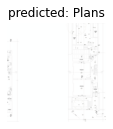

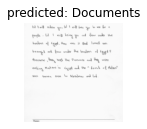

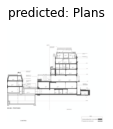

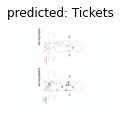

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### 6. Evaluating the model predictions

Now we compute and print the classification report, which provides the main classification metrics:
precision, recall and f1-score per class, the number of samples per class and 

*   precision
*   recall and f1-score per class
*   the number of samples per class
*   the global accuracy

We also compute and display the confussion matrix for the training and for the testing set. We normalize the values of the confusion matrix by raws (true class).



Train set classification report

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       344
           1       0.98      0.97      0.98       606
           2       0.97      0.99      0.98       470

    accuracy                           0.97      1420
   macro avg       0.97      0.97      0.97      1420
weighted avg       0.97      0.97      0.97      1420



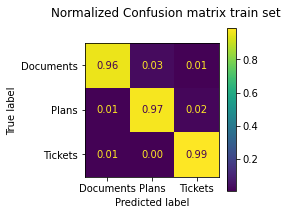

Validation set classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       181
           1       1.00      0.99      1.00       203
           2       0.99      1.00      0.99       156

    accuracy                           1.00       540
   macro avg       1.00      1.00      1.00       540
weighted avg       1.00      1.00      1.00       540



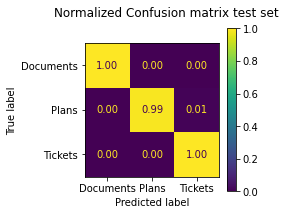

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in dataloaders['train']:
       
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_conv(inputs)
        output = (torch.max(output, 1)[1]).data.cpu().numpy()
        y_pred.extend(output) #save prediction

        labels =labels.data.cpu().numpy()
        y_true.extend(labels)   #save truth

print("Train set classification report\n")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true,y_pred,normalize='true')
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(3,3))
display.plot(ax=ax, values_format='.2f')
fig.suptitle('Normalized Confusion matrix train set')
plt.show()

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
       
        inputs, labels = inputs.to(device), labels.to(device)

        output = model_conv(inputs)
        output = (torch.max(output, 1)[1]).data.cpu().numpy()
        y_pred.extend(output) #save prediction

        labels =labels.data.cpu().numpy()
        y_true.extend(labels)   #save truth

print("Test set classification report\n")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true,y_pred, normalize='true')
display = ConfusionMatrixDisplay(cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(3,3))
display.plot(ax=ax, values_format='.2f')
fig.suptitle('Normalized Confusion matrix test set')
plt.show()

### 7. Saving the model

After finalizing, we save the model to file. Once saved, we can load the model at any time and use it to make predictions. 

we must call model. eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

In [ ]:
print(ROOT)

/content/drive/MyDrive/ColabNotebooks/


In [ ]:
# Specify a path
MODEL_PATH = ROOT+"classification_model_HP.pt"
# Save
torch.save(model_conv, MODEL_PATH)

In [ ]:
# Load
model = torch.load(MODEL_PATH)
model.eval()

### 8. Predicting single image using the model

This will involve two parts, one where we prepare the image so that it can be fed to ResNet, and next, we will write the code to get the actual prediction from the model.

#### 8.1. Preparing the image

ResNet model requires the image to be of 3 channel RGB of size 224 x 224. We will also normalize the image tensor with the required mean and standard deviation values.

We will use transforms from torchvision library and build a transform pipeline, which transforms our images as required.

Takes image data in bytes, applies the series of transforms, and returns a tensor. 

In [12]:
data_transforms['test']

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [37]:
from PIL import Image

def image_loader(imagen_name):
  image = plt.imread(imagen_name)
  imgFile = Image.open(imagen_name)

  if imgFile.mode == 'L':
    plt.imshow(image, cmap='gray')
    imgFile = imgFile.convert('RGB')
  else:
    plt.imshow(image)
  
  return data_transforms['test'](imgFile).unsqueeze(0)

#### 8.2. Classifying the image

Now we use the trained model to predict the image class, so we load the model and get an inference.

In [11]:
doc_type = {'Documents': 'document', 'Plans': 'plan', 'Tickets': 'ticket'}

ticket at confidence score:0.99


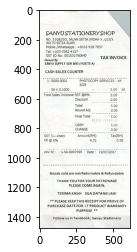

In [38]:
model_conv = torch.load(MODEL_PATH)
model_conv.eval()
 
def get_prediction(image):
    tensor = image_loader(image)
    tensor = tensor.to(device)
    output = model_conv.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes_output = torch.max(probs, 1)
    return conf.item(), doc_type[class_names[classes_output.item()]]

 
#image_path="/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Plans/Drawing-1167109_reconstructed.png"
#image_path="/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Documents/e01-035.png"
image_path="/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Tickets/498.jpg"

conf,y_pre=get_prediction(image_path)
print(y_pre, 'at confidence score:{0:.2f}'.format(conf))

#with open(ROOT+'outputClassifier.txt', 'a') as f:
#  content = 'Image {}, is a {} at confidence score: {:.2f}\n'.format(image_path, y_pre, conf)
#  f.write(content)

plan at confidence score:0.98


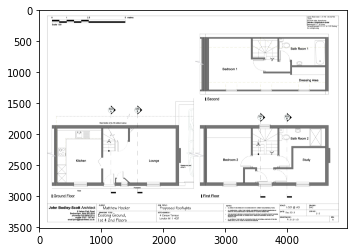

In [39]:
model_conv2 = torch.load(MODEL_PATH)
model_conv2.eval()

def get_prediction(image):
    tensor = image_loader(image)
    tensor = tensor.to(device)
    output = model_conv2.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes_output = torch.max(probs, 1)
    return conf.item(), doc_type[class_names[classes_output.item()]]

 
image_path="/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Plans/Drawing-1167109_reconstructed.png"
#image_path="/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Documents/e01-035.png"
#image_path="/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Tickets/498.jpg"

conf,y_pre=get_prediction(image_path)
print(y_pre, 'at confidence score:{0:.2f}'.format(conf))

with open(ROOT+'outputClassifier.txt', 'a') as f:
  content = 'Image {}, is a {} at confidence score: {:.2f}'.format(image_path, y_pre, conf)
  f.write(content)

document at confidence score:0.99


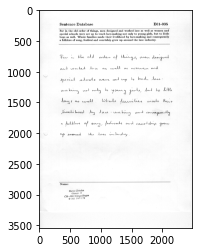

In [41]:
def get_prediction(image):
    tensor = image_loader(image)
    tensor = tensor.to(device)
    output = model_conv.forward(tensor)
     
    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes_output = torch.max(probs, 1)
    return conf.item(), doc_type[class_names[classes_output.item()]]

 
#image_path="/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Plans/Drawing-1167109_reconstructed.png"
image_path="/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Documents/e01-035.png"
#image_path="/content/drive/MyDrive/ColabNotebooks/DatabaseOrdered/test/Tickets/498.jpg"

conf,y_pre=get_prediction(image_path)
print(y_pre, 'at confidence score:{0:.2f}'.format(conf))

with open(ROOT+'outputClassifier.txt', 'a') as f:
  content = 'Image {}, is a {} at confidence score: {:.2f}'.format(image_path, y_pre, conf)
  f.write(content)